# GOAL

We want to analyze what happens in the 5 seconds after a team loses the ball, and measure how quickly/efficiently they recover it (the “5-second rule”).

In [1]:
import pandas as pd
import psycopg2
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database connection
conn = psycopg2.connect(
    host=os.getenv("PG_HOST"),
    database=os.getenv("PG_DB"),
    user=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD"),
    port=os.getenv("PG_PORT"),
    sslmode="require"
)


In [2]:
query = "SELECT DISTINCT name FROM eventtypes;"
event_names_df = pd.read_sql_query(query, conn)
event_names_df


,name
0,GENERIC:end delay
1,TAKE_ON
2,GENERIC:foul throw in
3,GENERIC:challenge
4,GENERIC:error
5,GENERIC:ball touch
6,GOALKEEPER
7,SUBSTITUTION
8,GENERIC:contentious referee decision
9,DUEL


### Load All Events

In [3]:
query = """
SELECT 
    me.event_id, 
    me.match_id, 
    me.team_id, 
    me.player_id, 
    me.timestamp, 
    me.x, 
    me.y,
    me.success,
    et.name AS event_name
FROM matchevents me
JOIN eventtypes et ON me.eventtype_id = et.eventtype_id
ORDER BY me.timestamp;
"""

all_events_df = pd.read_sql_query(query, conn)
all_events_df.head()


,event_id,match_id,team_id,player_id,timestamp,x,y,success,event_name
0,2721900799,616kggdv0monqet88gm079tsk,6vyr13j6kbwdtxjwm1m4m8nu2,5don85s7097g5df42m429b8ix,0 days 00:00:00,0.0,0.0,None,SUBSTITUTION
1,2705553677,5sue6595uizdrssh0wv22egpg,89xivtxk59uzvhdsd6miao6tm,er6z557ns3jcjhgrsbtmsn6s4,0 days 00:00:00,0.0,0.0,None,SUBSTITUTION
2,2727075729,6drdicnjxpb4gc279bogttjpw,b7jmo07lqav0wfe2mtlzyspak,7e0cr2upqlgq4btrm3h99bpey,0 days 00:00:00,0.0,0.0,None,SUBSTITUTION
3,2731739179,6h7k7hc45o9r2wva0jr055vys,3ix9om1svhd6obl0mbk1otgop,eg9qnjpbewow79ggttc0z2h3o,0 days 00:00:00,0.0,0.0,None,SUBSTITUTION
4,2728310143,6fal3n71n68p9j1pypcdabggk,3ix9om1svhd6obl0mbk1otgop,d4ppxjyzxjk3fm4agxpsani8k,0 days 00:00:00,0.0,0.0,None,SUBSTITUTION


### Filter Ball Loss Events

In [5]:
# Define ball loss events directly (including failed passes)
ball_loss_df = all_events_df[
    (all_events_df['event_name'].isin(['MISCONTROL', 'GENERIC:dispossessed', 'GENERIC:error'])) |
    ((all_events_df['event_name'] == 'PASS') & (all_events_df['success'] == False))
].copy()

# Reset index for clean loop later
ball_loss_df.reset_index(drop=True, inplace=True)
ball_loss_df.head()


,event_id,match_id,team_id,player_id,timestamp,x,y,success,event_name
0,2720924569,695t6yuiyw8q7bjv9nnll1atw,2989v3kho9h5jaboe1nr7lx21,5ak9fwtqlr2pll0nsv5br7p7u,0 days 00:00:00.021000,50.0,49.5,False,PASS
1,2708010037,5x3j66bwrma8tfs8yyohzgob8,7zibyotq1x1hq6pmgibhr0e6s,eg4piy0kcdtdopqpd3lcl5j2t,0 days 00:00:00.054000,50.0,50.0,False,PASS
2,2723703633,6ao2gvyiimquw8dlhisfsd2j8,6vyr13j6kbwdtxjwm1m4m8nu2,bu7cw3305zs2u7uj2ed5t867e,0 days 00:00:01.493000,45.8,59.5,False,PASS
3,2738650589,6odsz1jovznuwxmhla5r4cums,cyrrlv6l1onld5x247w1q1jlr,cfxzvlgvt9jj17qxq41t9sxcl,0 days 00:00:01.850000,42.8,49.7,False,PASS
4,2721009761,69j7bcf7os8kbk36hu1uwf9jo,cyrrlv6l1onld5x247w1q1jlr,d6eq2hlmwh2hpbx4m3qjiuxud,0 days 00:00:02.056000,33.1,48.3,False,PASS


### Feature Engineering – 5-Second Analysis

In [6]:
# Convert the 'timestamp' column (which is in timedelta format) to seconds
all_events_df['timestamp_sec'] = pd.to_timedelta(all_events_df['timestamp']).dt.total_seconds()
ball_loss_df['timestamp_sec'] = pd.to_timedelta(ball_loss_df['timestamp']).dt.total_seconds()


In [7]:
features = []

for _, row in ball_loss_df.iterrows():
    match_id = row['match_id']
    team_id = row['team_id']
    loss_time = row['timestamp_sec']
    
    window_df = all_events_df[
        (all_events_df['match_id'] == match_id) &
        (all_events_df['timestamp_sec'] > loss_time) &
        (all_events_df['timestamp_sec'] <= loss_time + 5)
    ]
    
    recovery_events = ['INTERCEPTION', 'RECOVERY', 'CLEARANCE', 'DUEL', 'GENERIC:challenge']
    pressing_events = ['DUEL', 'GENERIC:challenge']
    
    recovery = window_df[
        (window_df['team_id'] == team_id) &
        (window_df['event_name'].isin(recovery_events)) &
        (window_df['success'] == True)
    ]
    
    pressing = window_df[
        (window_df['team_id'] == team_id) &
        (window_df['event_name'].isin(pressing_events))
    ]
    
    opponent_passes = window_df[
        (window_df['team_id'] != team_id) &
        (window_df['event_name'] == 'PASS')
    ]

    recovery_time = recovery['timestamp_sec'].min() - loss_time if not recovery.empty else None

    features.append({
        'match_id': match_id,
        'team_id': team_id,
        'ball_loss_x': row['x'],
        'ball_loss_y': row['y'],
        'recovered_within_5s': int(not recovery.empty),
        'recovery_time': recovery_time,
        'num_pressing_actions': len(pressing),
        'opponent_passes_in_5s': len(opponent_passes)
    })

features_df = pd.DataFrame(features)
features_df.head()


,match_id,team_id,ball_loss_x,ball_loss_y,recovered_within_5s,recovery_time,num_pressing_actions,opponent_passes_in_5s
0,695t6yuiyw8q7bjv9nnll1atw,2989v3kho9h5jaboe1nr7lx21,50.0,49.5,0,NaN,0,2
1,5x3j66bwrma8tfs8yyohzgob8,7zibyotq1x1hq6pmgibhr0e6s,50.0,50.0,0,NaN,0,1
2,6ao2gvyiimquw8dlhisfsd2j8,6vyr13j6kbwdtxjwm1m4m8nu2,45.8,59.5,0,NaN,1,4
3,6odsz1jovznuwxmhla5r4cums,cyrrlv6l1onld5x247w1q1jlr,42.8,49.7,0,NaN,0,1
4,69j7bcf7os8kbk36hu1uwf9jo,cyrrlv6l1onld5x247w1q1jlr,33.1,48.3,1,4.484,1,3


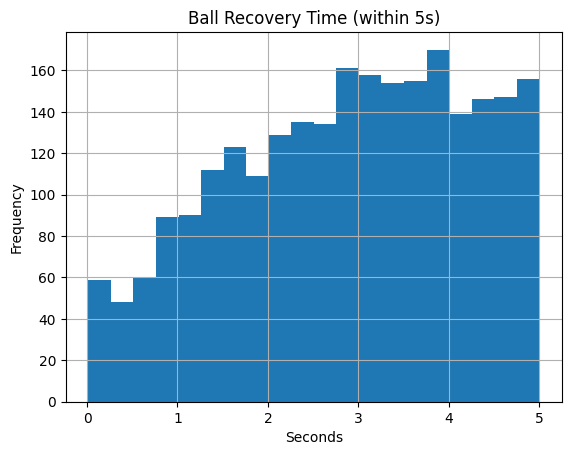

In [8]:
features_df['recovery_time'] = pd.to_numeric(features_df['recovery_time'], errors='coerce')

features_df['recovery_time'].dropna().hist(bins=20)
plt.title("Ball Recovery Time (within 5s)")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [9]:
# Pick a specific ball loss event to animate (you can try different ones)
example_event = ball_loss_df.iloc[0]

match_id = example_event['match_id']
loss_time = pd.to_timedelta(example_event['timestamp'])  # Already timedelta
loss_team = example_event['team_id']

# Set animation window: 5 seconds after ball loss
start_time = loss_time
end_time = loss_time + pd.to_timedelta("0 days 00:00:05")


In [10]:
query = f"""
SELECT pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
WHERE pt.game_id = '{match_id}'
ORDER BY pt.timestamp;
"""

tracking_df = pd.read_sql_query(query, conn)
tracking_df['timestamp'] = pd.to_timedelta(tracking_df['timestamp'])

In [11]:
animation_df = tracking_df[
    (tracking_df['timestamp'] >= start_time) &
    (tracking_df['timestamp'] <= end_time)
].copy()

animation_df.reset_index(drop=True, inplace=True)
frames = sorted(animation_df['timestamp'].unique())


In [ ]:
query = f"""
SELECT match_id, timestamp, x, y
FROM matchevents
WHERE match_id = '{match_id}'
ORDER BY timestamp;
"""

events_for_ball = pd.read_sql_query(query, conn)
events_for_ball['timestamp'] = pd.to_timedelta(events_for_ball['timestamp'])


In [13]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Setup the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 6))

def update(frame_time):
    ax.clear()
    pitch.draw(ax=ax)

    # Player data for this frame
    frame_players = animation_df[animation_df['timestamp'] == frame_time]

    # Plot players
    for _, row in frame_players.iterrows():
        color = 'red' if row['team_id'] == loss_team else 'blue'
        pitch.scatter(row['x'], row['y'], ax=ax, s=100, color=color, edgecolor='black')
        ax.text(row['x'] + 1, row['y'], str(row['jersey_number']), fontsize=8, color='black')

    # Ball position: find closest match event in time
    ball_event = events_for_ball.iloc[(events_for_ball['timestamp'] - frame_time).abs().argsort()[:1]]
    if not ball_event.empty:
        pitch.scatter(ball_event['x'], ball_event['y'], ax=ax, color='black', s=50, zorder=3, label='ball')

    ax.set_title(f"Ball Loss Transition | Time: {str(frame_time)[7:15]}", fontsize=12)

ani = FuncAnimation(fig, update, frames=frames, interval=250)
plt.close()  # prevents static plot
ani


In [14]:
ani

In [15]:
from IPython.display import HTML
from matplotlib import rc

rc('animation', html='jshtml')  # or 'html5' as alternative
HTML(ani.to_jshtml())  # or ani.to_html5_video()


In [17]:
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'public';
"""

tables_df = pd.read_sql_query(query, conn)
tables_df


,table_name
0,eventtypes
1,matches
2,matchevents
3,player_tracking
4,players
5,qualifiers
6,qualifiertypes
7,spadl_actions
8,teams
9,role_passwords


In [18]:
# Load team ID → team name mapping
team_query = "SELECT team_id, team_name FROM teams;"
teams_df = pd.read_sql_query(team_query, conn)



In [19]:
# Merge team names into your main features_df
features_named_df = features_df.merge(teams_df, on='team_id', how='left')


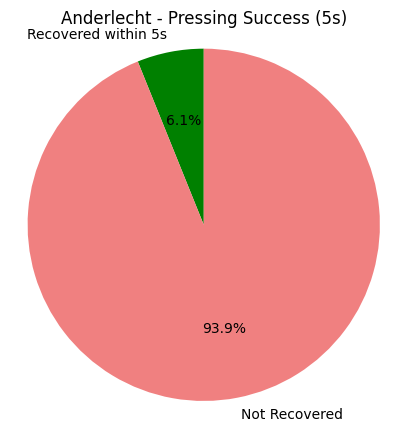

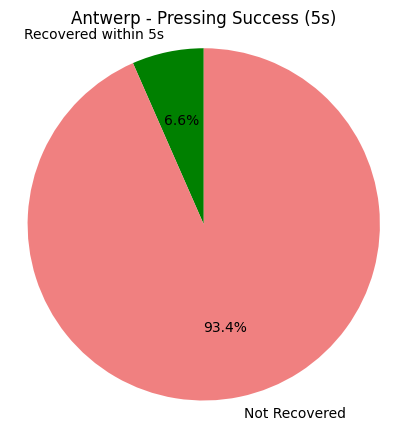

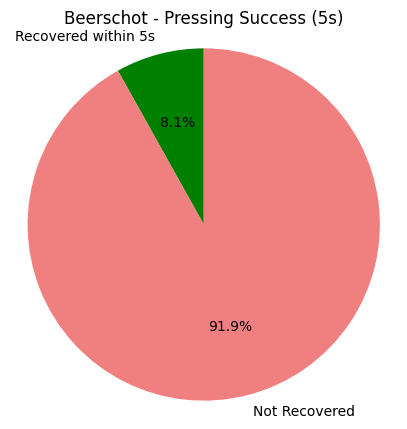

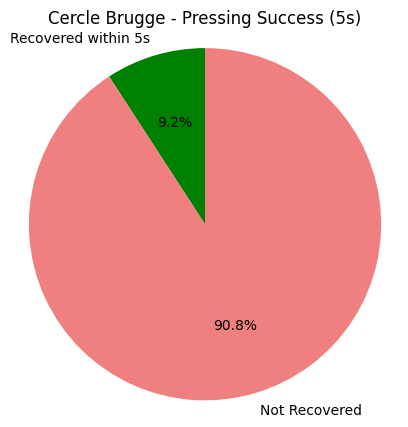

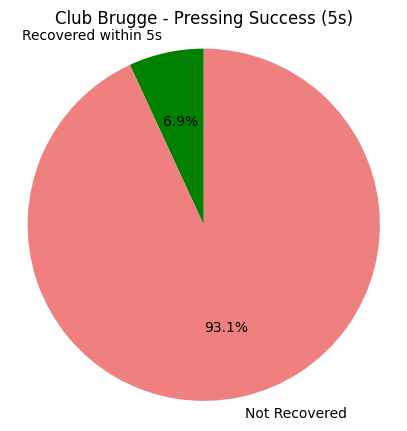

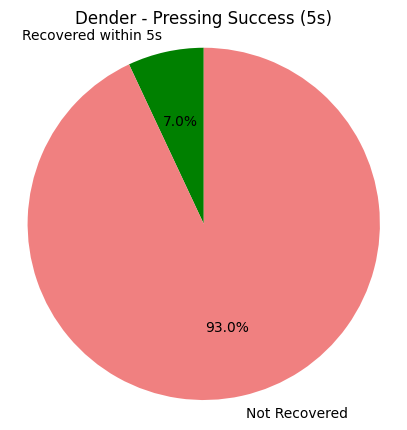

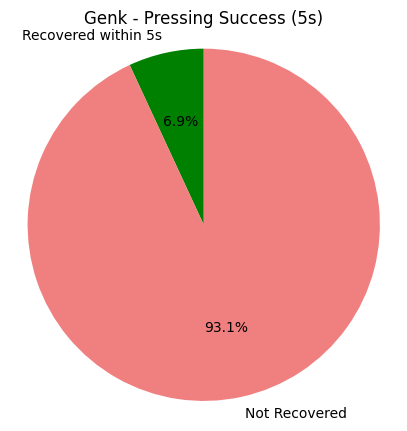

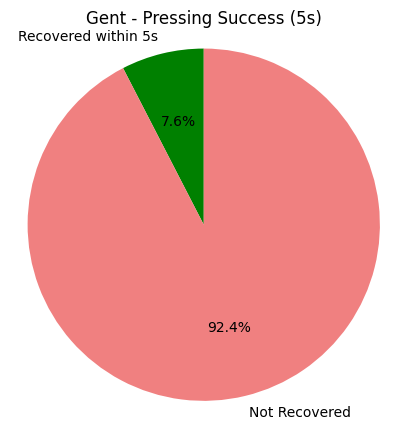

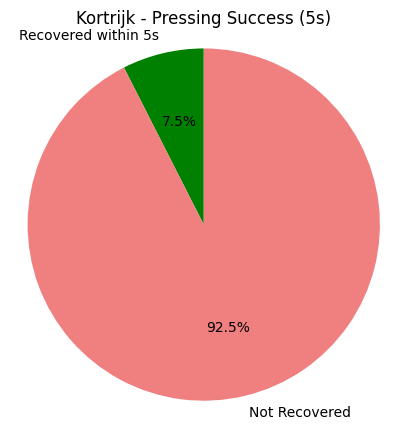

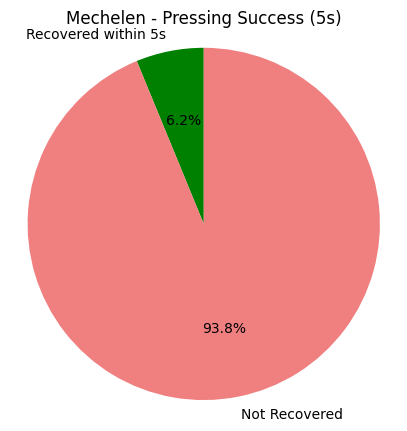

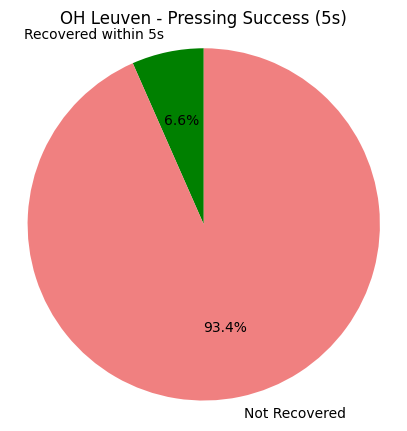

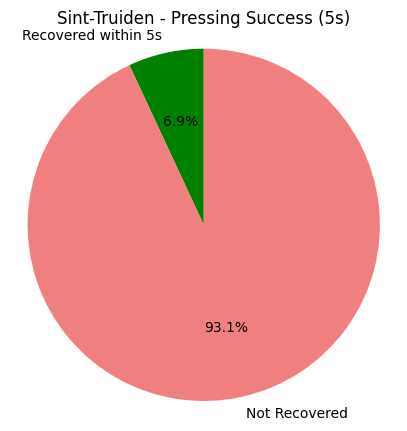

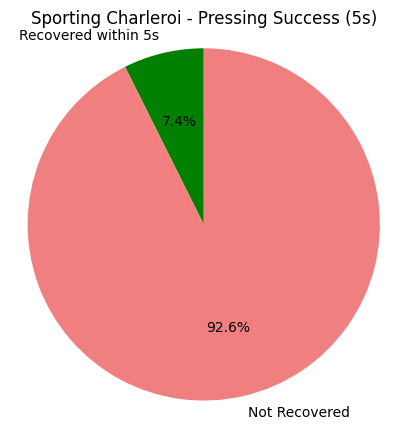

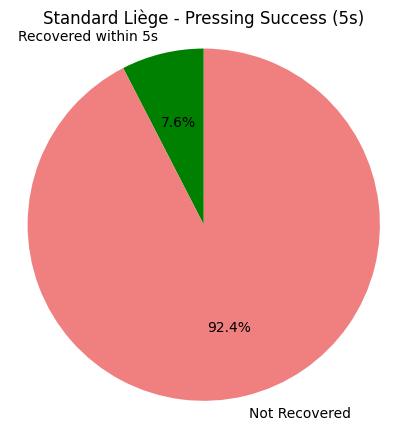

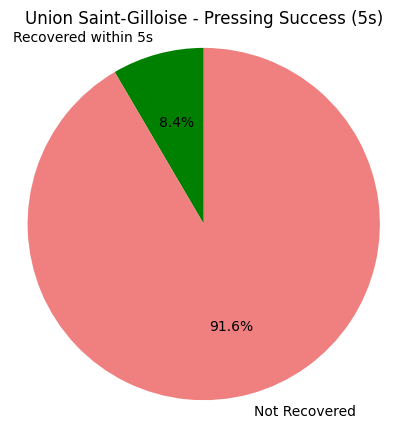

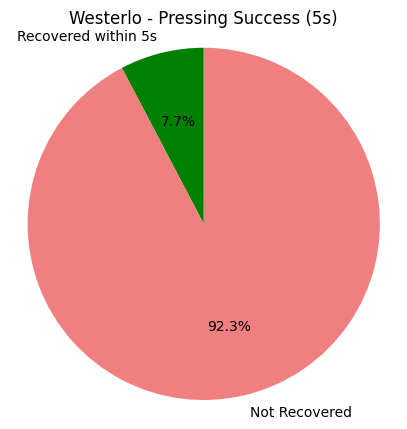

In [20]:
# Group by team name and count recoveries
team_results_named = features_named_df.groupby('team_name')['recovered_within_5s'].value_counts().unstack().fillna(0)

# Plot one pie per team
for team_name, row in team_results_named.iterrows():
    labels = ['Recovered within 5s', 'Not Recovered']
    values = [row.get(1, 0), row.get(0, 0)]
    colors = ['green', 'lightcoral']

    plt.figure(figsize=(5, 5))
    plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title(f'{team_name} - Pressing Success (5s)')
    plt.axis('equal')
    plt.show()


In [21]:
print(features_df.columns)


Index(['match_id', 'team_id', 'ball_loss_x', 'ball_loss_y',
       'recovered_within_5s', 'recovery_time', 'num_pressing_actions',
       'opponent_passes_in_5s'],
      dtype='object')


In [22]:
print(ball_loss_df.shape)


(33583, 10)


In [23]:
print(ball_loss_df['event_name'].unique())


['PASS' 'MISCONTROL' 'GENERIC:dispossessed' 'GENERIC:error']


In [24]:
print(type(all_events_df['timestamp'].iloc[0]))


<class 'str'>


In [25]:
print(type(all_events_df['timestamp'].iloc[0]))
print(type(ball_loss_df['timestamp'].iloc[0]))
print(all_events_df['timestamp'].iloc[0])

<class 'str'>
<class 'str'>
0 days 00:00:00


## Violin plot

### A clean way to compare recovery time distributions by team in one view.

C:\Users\Cristina\AppData\Local\Temp\ipykernel_25336\425405135.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


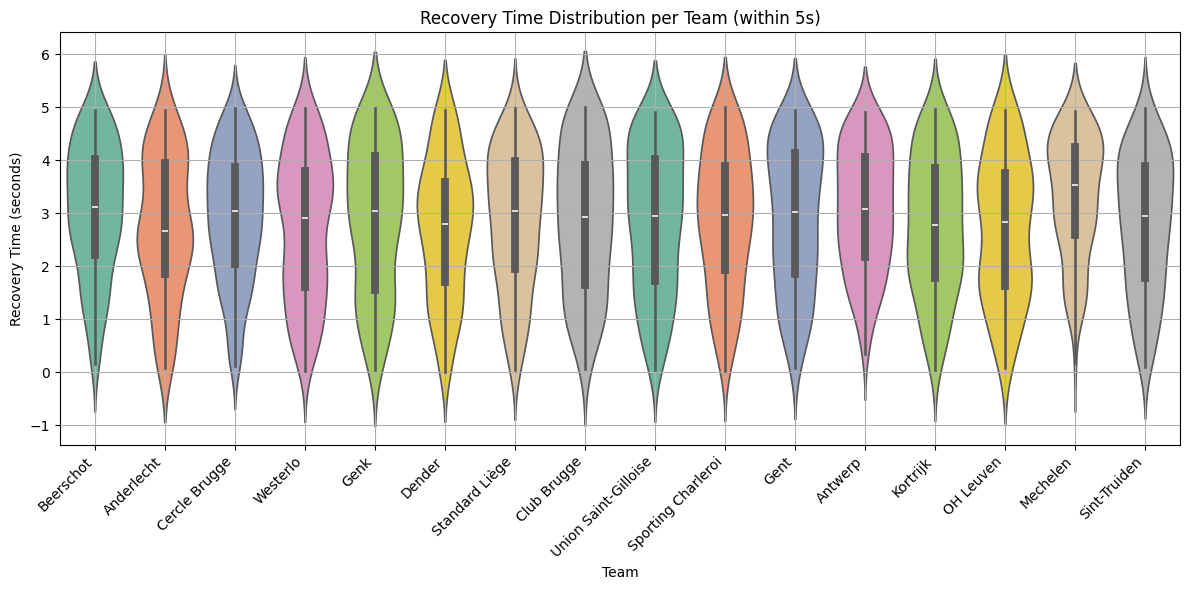

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: filter only successful recoveries
filtered_df = features_named_df[features_named_df['recovered_within_5s'] == 1]

plt.figure(figsize=(12, 6))
sns.violinplot(
    data=filtered_df,
    x='team_name',
    y='recovery_time',
    palette='Set2',
    inner='box'
)
plt.xticks(rotation=45, ha='right')
plt.title('Recovery Time Distribution per Team (within 5s)')
plt.ylabel('Recovery Time (seconds)')
plt.xlabel('Team')
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
# Calculate average recovery time per team (only for successful recoveries)
avg_recovery = features_named_df[features_named_df['recovered_within_5s'] == 1] \
    .groupby('team_name')['recovery_time'].mean().sort_values()

top_3_teams = avg_recovery.head(3)
print(top_3_teams)


team_name
OH Leuven     2.711278
Dender        2.719200
Anderlecht    2.722713
Name: recovery_time, dtype: float64


C:\Users\Cristina\AppData\Local\Temp\ipykernel_25336\1166893349.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


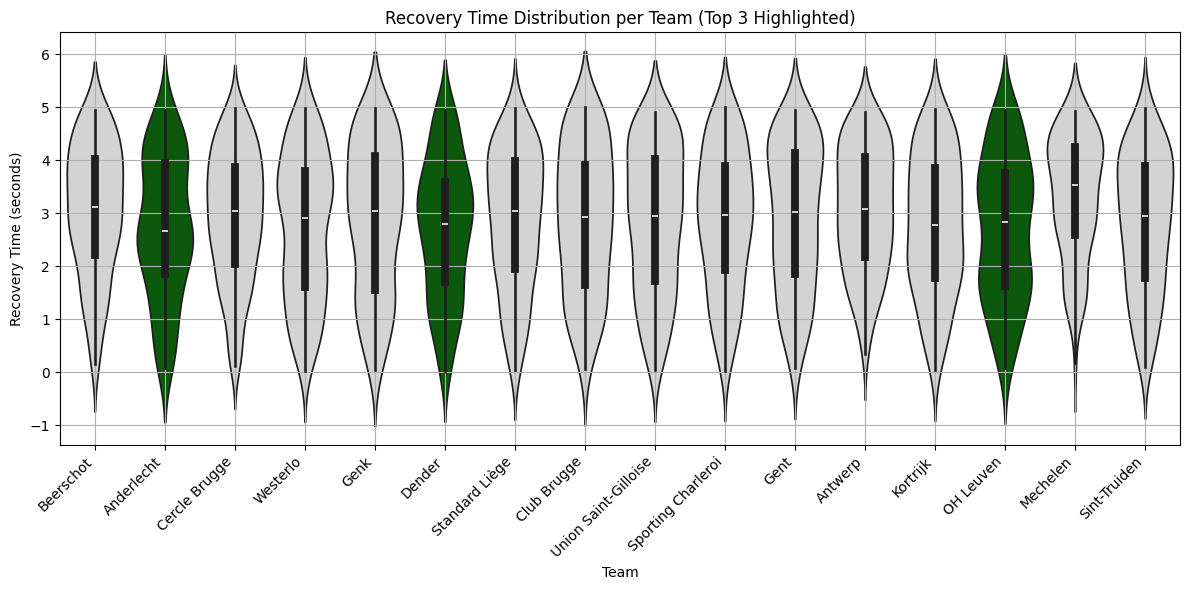

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Full team list in your filtered DataFrame
all_teams = filtered_df['team_name'].unique()

# Build full palette: top 3 = dark green, others = light gray
palette = {
    team: ('darkgreen' if team in highlight_teams else 'lightgray')
    for team in all_teams
}

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=filtered_df,
    x='team_name',
    y='recovery_time',
    palette=palette,
    inner='box'
)
plt.xticks(rotation=45, ha='right')
plt.title('Recovery Time Distribution per Team (Top 3 Highlighted)')
plt.ylabel('Recovery Time (seconds)')
plt.xlabel('Team')
plt.grid(True)
plt.tight_layout()
plt.show()


## Animation

In [36]:
# Pick first match and one ball loss event
first_match_id = all_events_df['match_id'].unique()[0]
ball_losses_first_match = ball_loss_df[ball_loss_df['match_id'] == first_match_id]
example_event = ball_losses_first_match.iloc[0]

loss_time = pd.to_timedelta(example_event['timestamp'])
loss_team = example_event['team_id']

# 5s window
start_time = loss_time
end_time = loss_time + pd.to_timedelta("0 days 00:00:05")


In [37]:
# Tracking data for players
query = f"""
SELECT pt.timestamp, pt.player_id, pt.x, pt.y, p.jersey_number, p.player_name, p.team_id
FROM player_tracking pt
JOIN players p ON pt.player_id = p.player_id
WHERE pt.game_id = '{first_match_id}'
ORDER BY pt.timestamp;
"""
tracking_df = pd.read_sql_query(query, conn)
tracking_df['timestamp'] = pd.to_timedelta(tracking_df['timestamp'])

# Events for ball position
query = f"""
SELECT timestamp, x, y
FROM matchevents
WHERE match_id = '{first_match_id}'
ORDER BY timestamp;
"""
events_for_ball = pd.read_sql_query(query, conn)
events_for_ball['timestamp'] = pd.to_timedelta(events_for_ball['timestamp'])


In [38]:
# Tracking data in 5s window
animation_df = tracking_df[
    (tracking_df['timestamp'] >= start_time) &
    (tracking_df['timestamp'] <= end_time)
].copy()

frames = sorted(animation_df['timestamp'].unique())

# Ball positions per frame (closest match event per timestamp)
ball_positions = []
for ts in frames:
    nearest = events_for_ball.iloc[(events_for_ball['timestamp'] - ts).abs().argsort()[:1]]
    if not nearest.empty:
        ball_positions.append((ts, nearest['x'].values[0], nearest['y'].values[0]))
    else:
        ball_positions.append((ts, None, None))
df_ball = pd.DataFrame(ball_positions, columns=['timestamp', 'x', 'y'])

# Separate players by team
df_home = animation_df[animation_df['team_id'] == loss_team].copy()
df_away = animation_df[animation_df['team_id'] != loss_team].copy()


In [47]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Setup pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(12, 8))

# Define marker styles
# marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
# ball_dot, = ax.plot([], [], ms=6, markerfacecolor='black', zorder=3, **marker_kwargs)
# home_dots, = ax.plot([], [], ms=10, markerfacecolor='red', **marker_kwargs)
# away_dots, = ax.plot([], [], ms=10, markerfacecolor='blue', **marker_kwargs)
marker_kwargs = {'marker': 'o', 'markeredgecolor': 'black', 'linestyle': 'None'}
ball_dot, = ax.plot([], [], ms=6, markerfacecolor='w', zorder=3, **marker_kwargs)
away_dots, = ax.plot([], [], ms=10, markerfacecolor='#b94b75', **marker_kwargs)  # red/maroon
home_dots, = ax.plot([], [], ms=10, markerfacecolor='#7f63b8', **marker_kwargs)  # purple

def animate(i):
    ts = frames[i]
    
    # Ball position
    ball_x = df_ball.iloc[i]['x']
    ball_y = df_ball.iloc[i]['y']
    ball_dot.set_data([ball_x], [ball_y])

    
    # Home (team that lost ball)
    home_frame = df_home[df_home['timestamp'] == ts]
    home_dots.set_data(home_frame['x'], home_frame['y'])
    
    # Away (opponent)
    away_frame = df_away[df_away['timestamp'] == ts]
    away_dots.set_data(away_frame['x'], away_frame['y'])

    ax.set_title(f"{first_match_id} | Ball Loss Transition | Time: {str(ts)[7:15]}", fontsize=14)
    return ball_dot, home_dots, away_dots

anim = FuncAnimation(fig, animate, frames=len(frames), interval=200, blit=True)
plt.close()
anim
